In [1]:
import numpy as np
import torch
import urllib.request as urllib
import matplotlib.pyplot as plt

import os
import sys
sys.path.append('src')

from util.loss_util import L2_Bern_loss_corrected, L2_Bern_loss
from util.model_util import RegressionNet
from datasets.toy import load_1d, RegressionData
from datasets.samplers import Bernoulli_batch_sampler, naive_Bernoulli_Dataloader
from uncertimators.MALA_unc import MALA_uncertimator
from uncertimators.non_bayes_unc import non_bayes_uncertimator

import seaborn as sns

# Set the color palette to a colorblind-friendly palette
sns.set_palette('colorblind')

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"



In [ ]:
def plot_fit(train_data, X_test, mean, std, save = False, folder = '.'):
    '''
    plotting function for the 1d regression example
    '''
    fs = 16

    m = mean[:,0].detach().cpu().numpy()
    s = std[:,0].detach().cpu().numpy()
    s_al =  0 

    f, ax = plt.subplots(1, 1, figsize=(8, 4))

    # Get upper and lower confidence bounds
    lower, upper = (m - s).flatten(), (m + s).flatten()
    # + aleotoric
    lower_al, upper_al = (m - s_al).flatten(), (m + s_al).flatten()

    # Plot training data as black stars
    X,Y = train_data
    ax.plot(X, Y, 'k*', rasterized=True)
    # Plot predictive means as blue line
    ax.plot(X_test, m, 'b', rasterized=True)
    # Shade between the lower and upper confidence bounds
    ax.fill_between(X_test.flatten(), lower, upper, alpha=0.5, rasterized=True)
    ax.fill_between(X_test.flatten(), lower_al, upper_al, alpha=0.2, rasterized=True)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-0.3, 1])
    plt.grid()
    ax.legend(['Observed Data', 'Mean', 'Epistemic', 'Aleatoric'], fontsize = fs)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)

    bbox = {'facecolor': 'white', 'alpha': 0.8, 'pad': 1, 'boxstyle': 'round', 'edgecolor':'black'}

    plt.tight_layout()
    if save:
        f.savefig(folder + '/full.pdf')
        
    plt.show()

def plot_doc_dict(uncert):  
    '''
    function that loops over all quantities tracked during the chain perfomed in "uncert"
    '''
    n_figs = len(uncert.doc_dict.keys())
    if n_figs < 10:
        _, ax = plt.subplots(5,2, figsize = (20,25))
    else:
        _, ax = plt.subplots(6,4, figsize = (20,30))
    ax = ax.flatten()

    for i, key in enumerate(uncert.doc_dict.keys()):
        if not key == 'acceptance_prob':
            p3 = ax[i].plot(uncert.doc_dict[key], label = r'$\sigma$ constant, start lr $ = 10^{-3}$')
        if key == 'acceptance_prob':
            ax[i].set_ylim(-0.1,1.5)
            t = np.mean(np.clip(np.array(uncert.doc_dict[key]),0,1))
            p3 = ax[i].plot(np.clip(np.array(uncert.doc_dict[key]),0,1), label = r'$\sigma$ constant, start lr $ = 10^{-3}$')
            ax[i].text(0,1, f'mean acc-prob {t:.3}', bbox = {'color': p3[0].get_color()})
        if key in ['sigma', 'old_new_sqe', 'prop_next_sqe', 'lr']:
            ax[i].set_yscale('log')

            
        ax[i].set_title(key)
        ax[i].grid()   
        ax[i].vlines(uncert.doc_dict['steps_sampling'], *ax[i].get_ylim(), color='orange')
    ax[0].legend()
    plt.show()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

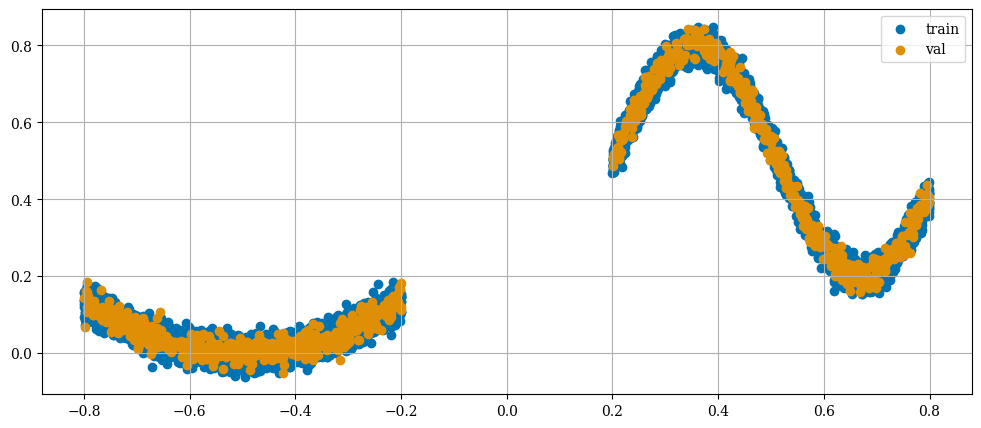

In [ ]:
n_points = 10000
p = 0.5 #rho
sigma_data=0.02
load = True
folder = './figs/StochasticMH/sigma_data_002/n10000/lambda1/'


X_tmp, Y_tmp = load_1d(folder, n_points, sigma_data)
X = torch.Tensor(X_tmp).view(-1,1)
Y = torch.Tensor(Y_tmp).view(-1,1)
train_data = (X.detach().cpu().numpy(), Y.detach().cpu().numpy())

X_tmp, Y_tmp = load_1d(folder, 1000, sigma_data)
X_val = torch.Tensor(X_tmp).view(-1,1)
Y_val = torch.Tensor(Y_tmp).view(-1,1)

X_test = torch.linspace(-1,1,500).view(-1,1)

data_tr = RegressionData(X, Y)
data_val = RegressionData(X_val, Y_val)

bs_tr = Bernoulli_batch_sampler(p, len(data_tr))
dataloader_tr = naive_Bernoulli_Dataloader(data_tr, p)
dataloader_val = torch.utils.data.DataLoader(data_val, batch_size=len(X_val),
                        shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

plt.figure(figsize=(12,5))
plt.scatter(X.detach().cpu().numpy(),Y.detach().cpu().numpy(), label = 'train')
plt.scatter(X_val.detach().cpu().numpy(),Y_val.detach().cpu().numpy(), label = 'val')
plt.legend()
plt.grid()
plt.show()

The first part of the Notebook includes allows us to test the algorithm we want to compare

# Adam fit

In [5]:
data = {'train': dataloader_tr, 'val': dataloader_val}
loss = L2_Bern_loss(n_points, p, use_mean=False)
net = RegressionNet(dim_in=1, dim_out=1, ndf=100, dropout=0, activation=torch.nn.ReLU, layers=3*[torch.nn.Linear], layer_kwargs=3*[{}], device=device).to(device)

uncert_Adam = non_bayes_uncertimator(net, loss, data, device)

In [6]:
if not load: 
    uncert_Adam.train(50000, {'opt': torch.optim.Adam(net.parameters(), lr = 1e-3), 'gamma_scheduler': 0.99})

    plt.figure(figsize=(10,8)) 
    plt.scatter(X_val.detach().cpu().numpy(), Y_val.detach().cpu().numpy(), label = 'train', alpha = 0.2)
    plt.plot(X_test.numpy(), uncert_Adam.model(X_test.to(uncert_Adam.device)).detach().cpu().numpy(), label = r'$\hat{f}_{\mathrm{GD}}$', color = 'C1')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,8)) 
    plt.plot(uncert_Adam.doc_dict['train_loss'], label = 'train')
    plt.plot(uncert_Adam.doc_dict['val_loss'], label = 'test')
    plt.yscale('log')
    plt.legend()
    plt.show()

# Full MH

In [ ]:
MCMC_dict = {'full_loss': True,
             'MH': True, #this is a little more than x2 runtime
             'sigma': 0.2,
             'sigma_factor': 1, 
             'lr_start': 1e-4, 
             'temperature': n_points*p,
             'verbose': False,
             'sigma_adam_dir': None,
             'opt': 'SGD', 
}

data = {'train': dataloader_tr, 'val': dataloader_val}
loss = L2_Bern_loss(n_points, p, use_mean=False)
net = RegressionNet(dim_in=1, dim_out=1, ndf=100, dropout=0, activation=torch.nn.ReLU, layers=3*[torch.nn.Linear], layer_kwargs=3*[{}], device=device).to(device)

warm_up_unc = non_bayes_uncertimator(net, loss, data, device)
uncert_MHgd = MALA_uncertimator(net, loss, data, device)

In [8]:
if not load: 
    warm_up_unc.train(1000, {'opt': torch.optim.SGD(net.parameters(), lr = 1e-3)})
    uncert_MHgd.warm_up(2500, **MCMC_dict)
    mean_MHgd, std_MHgd = uncert_MHgd.get_mean_and_std(X_test.to(device), 5, 500)

    uncert_MHgd.save(folder +'/MHgd/')
    torch.save(mean_MHgd, folder +'/MHgd/'+'mean.pt')
    torch.save(std_MHgd, folder +'/MHgd/'+'std.pt')

    plot_fit(train_data, X_test.detach().cpu().numpy(), mean_MHgd, std_MHgd)
    plot_doc_dict(uncert_MHgd)

# Stochastic MH

In [ ]:
data = {'train': dataloader_tr, 'val': dataloader_val}
net = RegressionNet(dim_in=1, dim_out=1, ndf=100, dropout=0, activation=torch.nn.ReLU, layers=3*[torch.nn.Linear], layer_kwargs=3*[{}], device=device).to(device)

MCMC_dict = {'full_loss': False,
             'MH': True, #this is a little more than x2 runtime
             'sigma': 0.2,
             'sigma_factor': 1, 
             'lr_start': 1e-4,
             'temperature': n_points*p,
             'verbose': False,
             'sigma_adam_dir': None, 
             'opt': 'SGD', 
             'fixed_batches': False
}

loss = L2_Bern_loss(n_points, p, use_mean=False)

warm_up_unc = non_bayes_uncertimator(net, loss, data, device)
uncert_sMHgd = MALA_uncertimator(net, loss, data, device)

In [10]:
if not load: 
    warm_up_unc.train(1000, {'opt': torch.optim.SGD(net.parameters(), lr = 1e-3)})
    uncert_sMHgd.warm_up(5000, **MCMC_dict)
    mean_sMHgd, std_sMHgd = uncert_sMHgd.get_mean_and_std(X_test.to(device), 5, 1000)

    uncert_sMHgd.save(folder + '/sMHgd/')
    torch.save(mean_sMHgd, folder +'/sMHgd/'+'mean.pt')
    torch.save(std_sMHgd, folder +'/sMHgd/'+'std.pt')
    
    plot_fit(train_data, X_test.detach().cpu().numpy(), mean_sMHgd, std_sMHgd)
    plot_doc_dict(uncert_sMHgd)
    plt.scatter(np.arange(len(uncert_sMHgd.doc_dict['accepted']))[uncert_sMHgd.doc_dict['accepted']],uncert_sMHgd.doc_dict['batch_size_acc'])
    plt.show()

# Stochastic MH  with correction

In [ ]:
data = {'train': dataloader_tr, 'val': dataloader_val}
net = RegressionNet(dim_in=1, dim_out=1, ndf=100, dropout=0, activation=torch.nn.ReLU, layers=3*[torch.nn.Linear], layer_kwargs=3*[{}], device=device).to(device)

MCMC_dict = {'full_loss': False,
             'MH': True, #this is a little more than x2 runtime
             'sigma': 0.02,
             'sigma_factor': 1,
             'lr_start': 1e-4/p,
             'temperature': n_points,
             'verbose': False,
             'sigma_adam_dir': None, 
             'opt': 'SGD',
             'fixed_batches': False

}

loss = L2_Bern_loss_corrected(n_points, p, MCMC_dict['temperature'], use_mean=False, k= 'run_avg')
loss_full = None #L2_Bern_loss_corrected(n_points, p, MCMC_dict['temperature'], use_mean=False, k= 'run_avg')
loss_train = L2_Bern_loss(n_points, p, use_mean=False)
loss_val = L2_Bern_loss(n_points, p, use_mean=False)

warm_up_unc = non_bayes_uncertimator(net, loss_train, data, device)
uncert_sMHgd_corr_k = MALA_uncertimator(net, loss, data, device, loss_full = loss_full, loss_train = loss_train, loss_val = loss_val)

In [12]:
if not load: 
    warm_up_unc.train(5000, {'opt': torch.optim.SGD(net.parameters(), lr = 1e-3)})
    loss.set_corr_factor(net(data['train'].dataset.x_train.reshape(-1,1).to(device = device, dtype = torch.float32)), 
                            data['train'].dataset.y_train.reshape(-1,1).to(device = device, dtype = torch.float32))
    uncert_sMHgd_corr_k.warm_up(2000, **MCMC_dict)
    mean_sMHgd_corr_k, std_sMHgd_corr_k = uncert_sMHgd_corr_k.get_mean_and_std(X_test.to(device), 5, 1000)

    uncert_sMHgd_corr_k.save(folder + '/sMHgd_corr/')
    torch.save(mean_sMHgd_corr_k, folder +'/sMHgd_corr/'+'mean.pt')
    torch.save(std_sMHgd_corr_k, folder +'/sMHgd_corr/'+'std.pt')

    plot_fit(train_data, X_test.detach().cpu().numpy(), mean_sMHgd_corr_k, std_sMHgd_corr_k)
    plot_doc_dict(uncert_sMHgd_corr_k)
    plt.scatter(np.arange(len(uncert_sMHgd_corr_k.doc_dict['accepted']))[uncert_sMHgd_corr_k.doc_dict['accepted']],uncert_sMHgd_corr_k.doc_dict['batch_size_acc'])
    plt.show()

# Evals and Plots of multiple runs

The second part includes the plots shown in the paper. To generate the network samples required for the plots, first run <code>StochasticMH_Adam_baseline.py</code>, as well as <code>StochasticMH.py</code> for $10$ distinct runs (by varying the <code>folder</code> variable). For <code>StochasticMH.py</code> this includes runs at $\rho = 0.1, 0.3, 0.5$ for $10000$ points as well as $\rho = 1.0, 0.5, 0.33, 0.1$ at $1000, 2000, 3000$ and $10000$ respectively.

In [ ]:
def smooth(x, kernel_size=5):
    if kernel_size == 1:
        return x
    else:
        assert kernel_size % 2 != 0
        x_shape = x.shape
        x_tmp = np.array([x[i:x_shape[0]-kernel_size+i+1] for i in range(kernel_size)])
        edge1 = x[:int((kernel_size-1)/2)]
        edge2 = x[-int((kernel_size-1)/2):]
        x_out = np.concatenate((edge1, np.mean(x_tmp, 0),edge2),0)
        assert x_shape == x_out.shape
        return x_out 

In [ ]:
folder = './figs/StochasticMH/sigma_data_002/n10000/lambda1/'
folder_add = '' 

ps = ['01', '03', '05']
ps_all = [0.1, 0.3, 0.5]

ns = [0,1,2,3,4,5,6,7,8,9]

colors = ['C0', 'C1', 'C2', 'C3']
ks = 1501

In [36]:
Adam_losses, MHgd_losses, sMHgd_losses, sMHgd_corr_lrRho_temp2mRho_losses = [], [], [], []
MHgd_alpha, sMHgd_alpha, sMHgd_corr_lrRho_temp2mRho_alpha  = [], [], []
MHgd_batch_size_acc, sMHgd_batch_size_acc, sMHgd_corr_lrRho_temp2mRho_batch_size_acc  = [], [], []

for i,p in enumerate(ps):
    Adam_losses_tmp, MHgd_losses_tmp, sMHgd_losses_tmp, sMHgd_corr_lrRho_temp2mRho_losses_tmp = [], [], [], []
    MHgd_alpha_tmp, sMHgd_alpha_tmp, sMHgd_corr_lrRho_temp2mRho_alpha_tmp  = [], [], []
    MHgd_batch_size_acc_tmp, sMHgd_batch_size_acc_tmp, sMHgd_corr_lrRho_temp2mRho_batch_size_acc_tmp  = [], [], []

    for n in ns:
        full_path = folder + f'rho{p}/' + folder_add + f'/{n}/'

        try:
            uncert_Adam.load(full_path+'/Adam_baseline/')
            Adam_losses_tmp.append(smooth(np.array(uncert_Adam.doc_dict['val_loss']).squeeze()[2000:], 1))
        except:
            pass

        uncert_MHgd.load(full_path+'/MHgd/samples/sample_19/')
        MHgd_losses_tmp.append(smooth(np.array(uncert_MHgd.doc_dict['val_loss']).squeeze(), ks))
        MHgd_alpha_tmp.append(np.array(uncert_MHgd.doc_dict['acceptance_prob']).squeeze())
        MHgd_batch_size_acc_tmp.append(np.array(uncert_MHgd.doc_dict['batch_size_acc']).squeeze())

        uncert_sMHgd.load(full_path+'/sMHgd/samples/sample_19/')
        sMHgd_losses_tmp.append(smooth(np.array(uncert_sMHgd.doc_dict['val_loss']).squeeze(), ks))
        sMHgd_alpha_tmp.append(np.array(uncert_sMHgd.doc_dict['acceptance_prob']).squeeze())
        sMHgd_batch_size_acc_tmp.append(np.array(uncert_sMHgd.doc_dict['batch_size_acc']).squeeze())

        uncert_sMHgd_corr_k.load(full_path+'/sMHgd_corr_lrRho/samples/sample_19/')
        sMHgd_corr_lrRho_temp2mRho_losses_tmp.append(smooth(np.array(uncert_sMHgd_corr_k.doc_dict['val_loss']).squeeze(), ks))
        sMHgd_corr_lrRho_temp2mRho_alpha_tmp.append(np.array(uncert_sMHgd_corr_k.doc_dict['acceptance_prob']).squeeze())
        sMHgd_corr_lrRho_temp2mRho_batch_size_acc_tmp.append(np.array(uncert_sMHgd_corr_k.doc_dict['batch_size_acc']).squeeze())

    Adam_losses.append(Adam_losses_tmp)
    MHgd_losses.append(MHgd_losses_tmp)
    sMHgd_losses.append(sMHgd_losses_tmp)
    sMHgd_corr_lrRho_temp2mRho_losses.append(sMHgd_corr_lrRho_temp2mRho_losses_tmp)
    MHgd_alpha.append(MHgd_alpha_tmp) 
    sMHgd_alpha.append(sMHgd_alpha_tmp) 
    sMHgd_corr_lrRho_temp2mRho_alpha.append(sMHgd_corr_lrRho_temp2mRho_alpha_tmp) 
    MHgd_batch_size_acc.append(MHgd_batch_size_acc_tmp) 
    sMHgd_batch_size_acc.append(sMHgd_batch_size_acc_tmp) 
    sMHgd_corr_lrRho_temp2mRho_batch_size_acc.append(sMHgd_corr_lrRho_temp2mRho_batch_size_acc_tmp) 

for a in [Adam_losses, MHgd_losses, sMHgd_losses, sMHgd_corr_lrRho_temp2mRho_losses, MHgd_alpha, sMHgd_alpha, sMHgd_corr_lrRho_temp2mRho_alpha, MHgd_batch_size_acc, sMHgd_batch_size_acc, sMHgd_corr_lrRho_temp2mRho_batch_size_acc]:
    a = np.array(a)

/home/bierings/.local/lib/python3.7/site-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


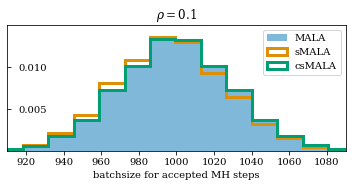

In [ ]:
bs = [20,20,20]
ticks = [[0.005, 0.010],[0.005, 0.010],[0.005]]
lims = [(910, 1090), (2860, 3140), (4860, 5140)]

fig, ax = plt.subplots(1, 1, figsize=(5,2.7))
ax = [ax]

for i,a in enumerate(ax):
    b = bs[i]
    dat_tmp = np.concatenate(MHgd_batch_size_acc[i])
    _,b,_ = a.hist(dat_tmp, bins=b, label = f'MALA', 
           density=True, color=colors[0], alpha=0.5)

    dat_tmp = np.concatenate(sMHgd_batch_size_acc[i])
    a.hist(dat_tmp, bins=b,  histtype='step', label = f'sMALA', 
           density=True, color=colors[1], linewidth=3)

    dat_tmp = np.concatenate(sMHgd_corr_lrRho_temp2mRho_batch_size_acc[i])
    a.hist(dat_tmp, bins=b,  histtype='step', label = f'csMALA',
           density=True, color=colors[2], linewidth=3)

    a.set_title(r'$\rho = $'+f'{float(ps[i])/10}')
    a.set_xlabel(r'batchsize for accepted MH steps')
    a.set_ylim(a.get_ylim()[0], a.get_ylim()[1]*1.05)
    a.set_xlim(lims[i])
    a.yaxis.set_ticks(ticks[i])
    a.tick_params(axis="y",direction="in", pad=-40)
    a.legend()

fig.tight_layout()
fig.subplots_adjust(wspace=0.)
fig.savefig('./figs/StochasticMH/sigma_data_002/n10000/lambda1/batchsizes.pdf')

In [38]:
def get_posterior_mean_loss(model,n_points, folder):
    loss_fct = L2_Bern_loss(n_points)
    posterior_mean_loss = np.zeros(len(os.listdir(folder+'/samples/')))
    for p in os.listdir(folder+'/samples/'):
        
        X_val, Y_val = load_1d(folder, n_points, sigma_data)

        model.load_state_dict(torch.load((folder+'/samples/'+p+'/model.pt')))
        Y_pred = model(torch.Tensor(X_val).to(model.device)).unsqueeze(0).detach().cpu()
        posterior_mean_loss = loss_fct(Y_pred[0], Y_val).numpy()
    return np.mean(posterior_mean_loss)

In [39]:
posterior_mean_loss_MHgd, posterior_mean_loss_sMHgd, posterior_mean_loss_csMHgd = np.zeros((len(ps), len(ns))), np.zeros((len(ps), len(ns))), np.zeros((len(ps), len(ns)))

for i,p in enumerate(ps):    
    for n in ns:
        full_path = folder + f'rho{p}/' + folder_add + f'/{n}/'
        posterior_mean_loss_MHgd[i,n] = get_posterior_mean_loss(net, 10000, full_path+'/MHgd/')
        posterior_mean_loss_sMHgd[i,n] = get_posterior_mean_loss(net, 10000, full_path+'/sMHgd/')
        posterior_mean_loss_csMHgd[i,n] = get_posterior_mean_loss(net, 10000,full_path+'/sMHgd_corr_lrRho/')

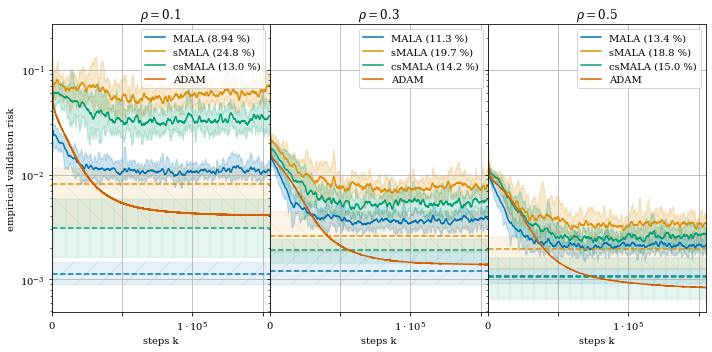

In [ ]:
fig, ax = plt.subplots(1, len(ps), figsize=(10,5), sharey = True)
ax = ax.flatten()

losses = [MHgd_losses, sMHgd_losses, sMHgd_corr_lrRho_temp2mRho_losses, Adam_losses]
posterior_mean_losses = [posterior_mean_loss_MHgd, posterior_mean_loss_sMHgd, posterior_mean_loss_csMHgd]
alphas = [MHgd_alpha, sMHgd_alpha, sMHgd_corr_lrRho_temp2mRho_alpha]

labels = [
          r'MALA ',
          r'sMALA ',
          r'csMALA ',
          r'ADAM',
          ]
hatches=['/', '\\', '|']
#offsets = [0,-100,-200]

for i,a in enumerate(ax):
    for j,l in enumerate(losses):
        dat_tmp = np.array(l[i])
        if j<3:
            alphas_tmp = np.array(alphas[j][i]).flatten()
            alpha = np.mean(np.clip(alphas_tmp,0,1))*100
            a.plot(np.mean(dat_tmp,0), label = labels[j] + f'({alpha:.3} %)', color = colors[j])
            a.fill_between(np.arange(len(dat_tmp[0])), dat_tmp.min(0), dat_tmp.max(0), color = colors[j], alpha = 0.2)
        
            a.hlines(np.mean(posterior_mean_losses[j][i]), 0, len(dat_tmp[0]), color = colors[j], linestyle='--')
            a.fill_between(np.arange(len(dat_tmp[0])), np.min(posterior_mean_losses[j][i]), np.max(posterior_mean_losses[j][i]), 
                        color=colors[j], alpha=0.1, edgecolor = colors[j], hatch= hatches[j])
            
        else:
            for qw in range(len(dat_tmp)):
                a.plot(np.mean(dat_tmp,0),  color = colors[j], alpha = 1., label = labels[j])


    a.legend()
    a.set_title(r'$\rho = $'+f'{float(ps[i])/10}')
    a.set_yscale('log')
    a.set_xlabel('steps k')
    a.set_xlim(0,155000)
    #a.set_ylim(0.0015,0.12)
    a.xaxis.set_ticks(np.arange(0,150001,50000), labels = [r'$0$','',r'$1\cdot 10^5$',''])
    a.grid()

ax[0].set_ylabel('empirical validation risk') 
fig.tight_layout()
fig.subplots_adjust(wspace=0.)
fig.savefig('./figs/StochasticMH/sigma_data_002/n10000/lambda1/losses_test.png', dpi = 500)

In [ ]:
folder_add = '' 

ns = [0, 1, 2, 3, 4, 5,6,7,8,9]
nds = [1000, 2000, 3000,10000]
s_rhos = ['1', '05', '033', '01']
rhos = [1.0, 0.5, 0.33, 0.1]

colors = ['C0', 'C1', 'C2', 'C3']

labels = [
          r'MALA ',# $\lambda L = \sum_i^n l_i$',
          r'sMALA ',# $\lambda L = \sum_i^{n_\mathrm{batch}} l_i$',
          r'csMALA ',#, lr/$\rho$ $\lambda L = \sum_i^{n_\mathrm{batch}} l_i + \log{\rho} \, n_\mathrm{batch}$',
          #r'Adam',
          ]

posterior_mean_loss_MHgd_nd, posterior_mean_loss_sMHgd_nd, posterior_mean_loss_csMHgd_nd = np.zeros((len(nds), len(ns))), np.zeros((len(nds), len(ns))), np.zeros((len(nds), len(ns)))

for i,nd in enumerate(nds): 
    folder = f'./figs/StochasticMH/sigma_data_002/n{nd}/lambda1/'   
    for n in ns:
        full_path = folder + f'rho{s_rhos[i]}/' + folder_add + f'/{n}/'
        posterior_mean_loss_MHgd_nd[i,n] = get_posterior_mean_loss(net, nd, full_path+'/MHgd/')
        posterior_mean_loss_sMHgd_nd[i,n] = get_posterior_mean_loss(net, nd, full_path+'/sMHgd/')
        posterior_mean_loss_csMHgd_nd[i,n] = get_posterior_mean_loss(net, nd, full_path+'/sMHgd_corr_lrRho/')

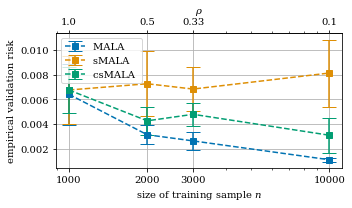

In [ ]:
posterior_mean_losses = [posterior_mean_loss_MHgd_nd, posterior_mean_loss_sMHgd_nd, posterior_mean_loss_csMHgd_nd]


fig, ax = plt.subplots(1, 1, figsize=(5,3))

for i, pml in enumerate(posterior_mean_losses):

    plt.errorbar(nds, pml.mean(1), yerr = pml.std(1),
                color=colors[i], 
                marker = 's', linestyle = '--', capsize=7.0, label = labels[i])

plt.xscale('log')
plt.grid()
secx = ax.secondary_xaxis('top')

ax.set_xticks(nds, labels=nds)
ax.set_xlabel(r'size of training sample $n$')
secx.set_xticks(nds, labels=[1.0, 0.5, 0.33, 0.1])
secx.set_xlabel(r'$\rho$')
ax.legend(loc = 'upper left')

ax.set_ylabel('empirical validation risk')

fig.tight_layout()
fig.subplots_adjust(wspace=0.)
fig.savefig('./figs/StochasticMH/sigma_data_002/n_scaling.pdf')
